## Loss

In [6]:
import matplotlib.pyplot as plt
from utils import Extractor

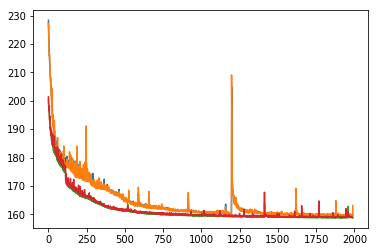

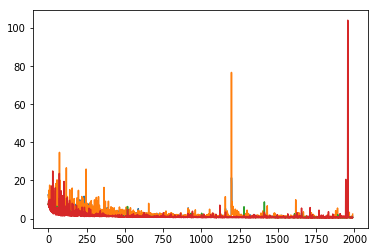

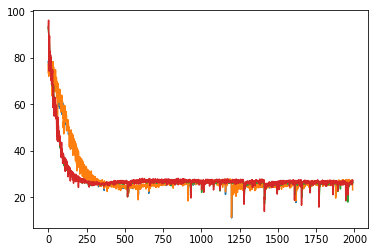

In [7]:
ext = Extractor("../logzero/Feb26_08-06-04.txt")
ext1 = Extractor("../logzero/Feb27_09-34-00.txt")

def plot(exts):
    for ext in exts:
        plt.plot(ext("train", "x_loss")[10:])
        plt.plot(ext("test", "x_loss")[10:])
    plt.show()
    for ext in exts:
        plt.plot(ext("train", "s_loss")[10:])
        plt.plot(ext("test", "s_loss")[10:])
    plt.show()
    for ext in exts:
        plt.plot(ext("train", "s_aux_loss")[10:])
        plt.plot(ext("test", "s_aux_loss")[10:])
    plt.show()

plot([ext, ext1])

In [9]:
ext("train", "x_loss")[-10:]

[159.6540531703404,
 159.59043404715402,
 159.5822745186942,
 159.61776776994978,
 159.59519609723773,
 159.64288242885044,
 159.7064435686384,
 159.59040919712612,
 159.5512468610491,
 160.14027361188616]

## Pred in env

In [3]:
import argparse
import os
import pickle
import sys
sys.path.append("../")
from model import SSM
from utils import load_model


parser = argparse.ArgumentParser()
parser.add_argument("--device", type=int, nargs="+", default=[0])
parser.add_argument("--s_dim", type=int, default=64)
parser.add_argument("--a_dim", type=int, default=6)
parser.add_argument("--o_dim", type=int, default=17)
parser.add_argument("--h_dim", type=int, default=128)
parser.add_argument("--timestamp", type=str, default=None)
parser.add_argument("--load_epoch", type=int, default=None)
args = parser.parse_args("\
    --device 0 \
    --timestamp Feb26_06-08-58 \
    --load_epoch 2000 \
    ".split())

model = SSM(args)
load_model(model, model_dir="../", epoch=args.load_epoch)

with open("../data/loop0/param.pkl", mode='rb') as f:
    a_mean, a_std, o_mean, o_std = pickle.load(f)

In [4]:
import gym
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from rlkit.envs.wrappers import NormalizedBoxEnv


env_name = 'HalfCheetah-v2'
# env = gym.make(env_name)
env = NormalizedBoxEnv(gym.make(env_name))

true = []
pred = []

o = env.reset()
o = o.astype(np.float32)
o = (o - o_mean) / o_std
o = torch.from_numpy(np.array([o]))
y = model.reset(o)

for t in range(300):
    # env.render()    
    a = env.action_space.sample()
    o, r, done, info = env.step(a)

    a = a.astype(np.float32)
    a = (a - a_mean) / a_std
    a = torch.from_numpy(np.array([a]))
    y = model.step(a)[0]
    y = y.cpu().detach().numpy()
    y = y * o_std + o_mean

    true.append(o)
    pred.append(y)

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


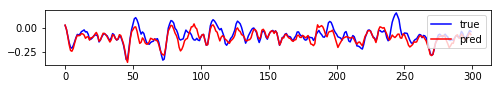

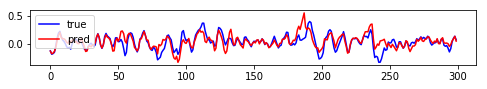

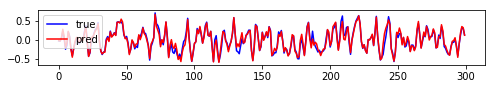

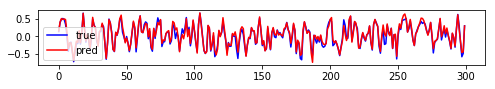

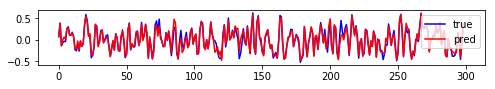

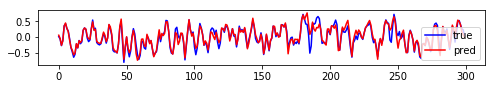

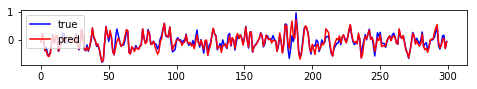

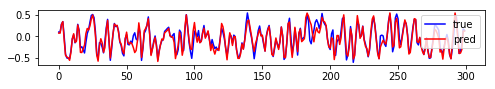

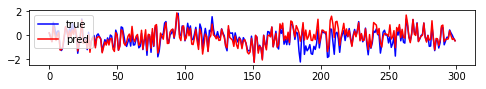

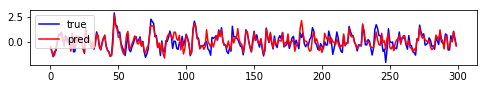

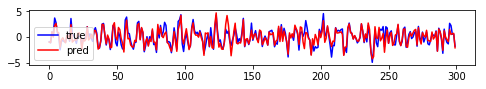

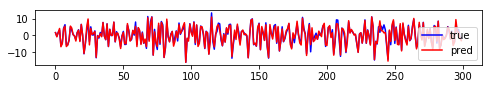

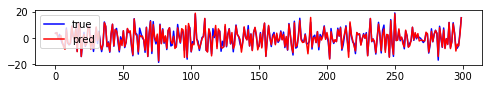

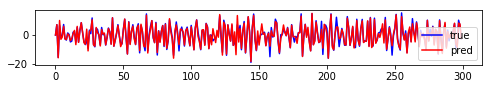

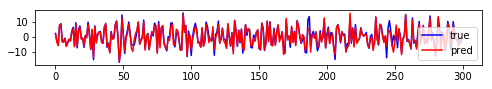

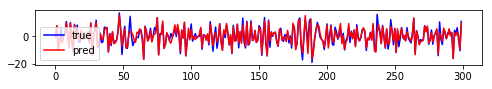

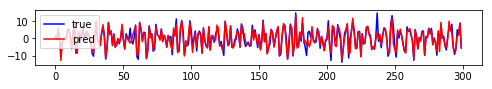

In [5]:
for k in range(len(pred[0])):
    plt.figure(figsize=(8,1))
    plt.plot(np.array(true)[:,k], c='b', label='true')
    plt.plot(np.array(pred)[:,k], c='r', label='pred')
    plt.legend()
    plt.show()

## Pred expert observation

- 四分位つける

In [53]:
import gym
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from rlkit.envs.wrappers import NormalizedBoxEnv

import argparse
import os
import pickle
import sys
sys.path.append("../")
from model import SSM
from utils import load_model


def eval_expert_loss(timestamp, load_epoch, param_path, data_path, show=False):
    parser = argparse.ArgumentParser()
    parser.add_argument("--device", type=int, nargs="+", default=[0])
    parser.add_argument("--s_dim", type=int, default=64)
    parser.add_argument("--a_dim", type=int, default=6)
    parser.add_argument("--o_dim", type=int, default=17)
    parser.add_argument("--h_dim", type=int, default=128)
    parser.add_argument("--timestamp", type=str, default=None)
    parser.add_argument("--load_epoch", type=int, default=None)
    args = parser.parse_args("\
        --device 0 \
        --timestamp {} \
        --load_epoch {} \
        ".format(timestamp, load_epoch).split())

    model = SSM(args)
    load_model(model, model_dir="../", epoch=args.load_epoch)

    with open(param_path, mode='rb') as f:
        a_mean, a_std, o_mean, o_std = pickle.load(f)

    with open(data_path, mode='rb') as f:
        data = pickle.load(f)

    traj_a = np.array([data[i][0] for i in range(len(data))],
                      dtype=np.float32)
    traj_o = np.array([data[i][1] for i in range(len(data))],
                      dtype=np.float32)
    # print(traj_a.shape, traj_o.shape)

    scores = []

    for trial in range(5):
        epis_a = traj_a[trial]
        epis_o = traj_o[trial]
        o, true = epis_o[0], epis_o[1:301]

        pred = []

        o = o.astype(np.float32)
        o = (o - o_mean) / o_std
        o = torch.from_numpy(np.array([o]))
        y = model.reset(o)

        for t in range(1, 301):
            a = epis_a[t]
            a = a.astype(np.float32)
            a = (a - a_mean) / a_std
            a = torch.from_numpy(np.array([a]))
            y = model.step(a)[0]
            y = y.cpu().detach().numpy()
            # y = y * o_std + o_mean

            pred.append(y)

        if trial == 0 and show:
            for k in range(len(pred[0])):
                print(k)
                plt.figure(figsize=(12,1))
                plt.plot(np.array(true)[:,k], c='b', label='true')
                plt.plot(np.array(pred)[:,k], c='r', label='pred')
                plt.legend()
                plt.show()

        true = (true - o_mean) / o_std
        # plt.figure(figsize=(12,2))
        # plt.plot(true[:100][10]); plt.plot(pred[:100][10]); plt.show()
        # use angle (rad) only
        # score = np.mean(np.sum(np.power(np.array(pred - true)[:,1:8], 2), axis=1))
        # use angular velocity (rad/s) only
        # score = np.mean(np.sum(np.power(np.array(pred - true)[:,10:17], 2), axis=1))
        score = np.mean(np.sum(np.power(np.array(pred - true), 2), axis=1))
        scores.append(score)

    return np.mean(scores), np.std(scores)

### 反復学習0

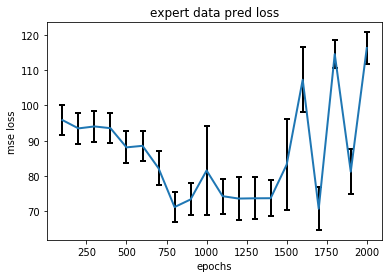

In [29]:
timestamp = "Feb26_08-06-04"
param_path = "../data/loop0/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []

for i in range(20):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*100, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*100 for i in range(20)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

### 反復学習1

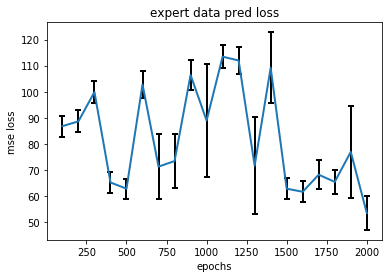

In [30]:
timestamp = "Feb27_09-34-00"
param_path = "../data/loop1/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []

for i in range(20):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*100, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*100 for i in range(20)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

### 反復学習2

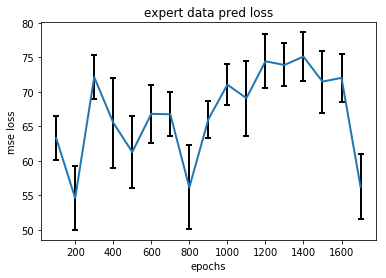

In [32]:
timestamp = "Mar01_04-57-45"
param_path = "../data/loop2_abci/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []
# score = eval_expert_loss(timestamp, 1000, param_path, data_path, show=True)
# print(score)

for i in range(17):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*100, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*100 for i in range(17)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 

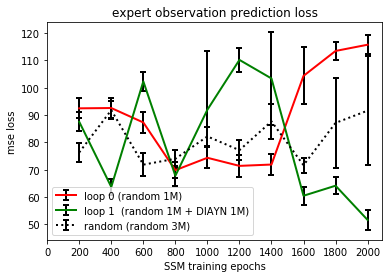

In [60]:
timestamp = "Feb26_08-06-04"
param_path = "../data/loop0/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []

for i in range(10):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2, color='r',
             label="loop 0 (random 1M)")

timestamp = "Feb27_09-34-00"
param_path = "../data/loop1/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []

for i in range(10):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2, color='g',
             label="loop 1  (random 1M + DIAYN 1M)")


# data3M
timestamp = "Feb28_22-11-54"
param_path = "../data/data3M/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist, std_hist = [], []

for i in range(10):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2, color='k', linestyle=':',
             label="random (random 3M)")

# timestamp = "Mar01_04-57-45"
# param_path = "../data/loop2_abci/param.pkl"
# data_path = "../data/data_expert.pkl"
# mean_hist = []
# std_hist = []

# for i in range(10):
#     print(i, end=" ")
#     mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
#     mean_hist.append(mean)
#     std_hist.append(std)

# plt.errorbar([(i+1)*200 for i in range(10)],
#              mean_hist, yerr=std_hist,
#              capsize=3, ecolor="black", linewidth=2, capthick=2, color='b', label="loop 2")
plt.title("expert observation prediction loss")
plt.xlabel("SSM training epochs")
plt.xticks([i*200 for i in range(11)], [i*200 for i in range(11)])
plt.ylabel("mse loss")
plt.legend(); plt.show()

- 最後だけ見れば…？

0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 

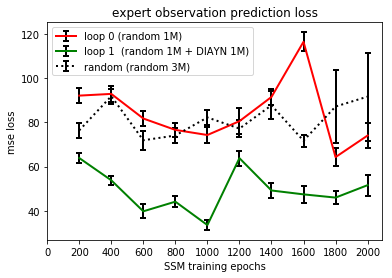

In [57]:
timestamp = "Feb28_14-10-06"
param_path = "../data/loop0_abci/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []

for i in range(10):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2, color='r',
             label="loop 0 (random 1M)")

timestamp = "Feb28_17-33-18"
param_path = "../data/loop1_abci/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []

for i in range(10):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2, color='g',
             label="loop 1  (random 1M + DIAYN 1M)")


# data3M
timestamp = "Feb28_22-11-54"
param_path = "../data/data3M/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist, std_hist = [], []

for i in range(10):
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2, color='k', linestyle=':',
             label="random (random 3M)")

# timestamp = "Mar01_04-57-45"
# param_path = "../data/loop2_abci/param.pkl"
# data_path = "../data/data_expert.pkl"
# mean_hist = []
# std_hist = []

# for i in range(10):
#     print(i, end=" ")
#     mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
#     mean_hist.append(mean)
#     std_hist.append(std)

# plt.errorbar([(i+1)*200 for i in range(10)],
#              mean_hist, yerr=std_hist,
#              capsize=3, ecolor="black", linewidth=2, capthick=2, color='b', label="loop 2")
plt.title("expert observation prediction loss")
plt.xlabel("SSM training epochs")
plt.xticks([i*200 for i in range(11)], [i*200 for i in range(11)])
plt.ylabel("mse loss")
plt.legend(); plt.show()

0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 

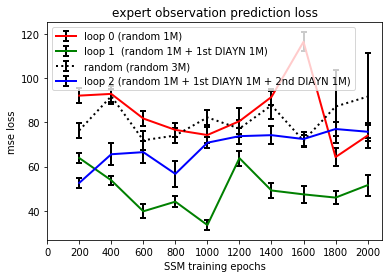

In [58]:
timestamp = "Feb28_14-10-06"
param_path = "../data/loop0_abci/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []

for i in range(10):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2, color='r',
             label="loop 0 (random 1M)")

timestamp = "Feb28_17-33-18"
param_path = "../data/loop1_abci/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []

for i in range(10):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2, color='g',
             label="loop 1  (random 1M + 1st DIAYN 1M)")


# data3M
timestamp = "Feb28_22-11-54"
param_path = "../data/data3M/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist, std_hist = [], []

for i in range(10):
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2, color='k', linestyle=':',
             label="random (random 3M)")

timestamp = "Mar01_04-57-45"
param_path = "../data/loop2_abci/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []

for i in range(10):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2, color='b',
             label="loop 2 (random 1M + 1st DIAYN 1M + 2nd DIAYN 1M)")

plt.title("expert observation prediction loss")
plt.xlabel("SSM training epochs")
plt.xticks([i*200 for i in range(11)], [i*200 for i in range(11)])
plt.ylabel("mse loss")
plt.legend(); plt.show()

### ランダムデータ

(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)


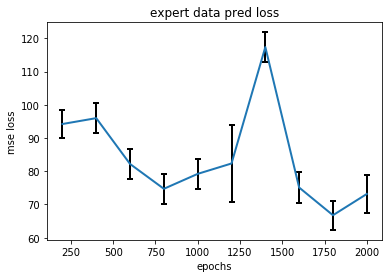

In [20]:
# data1M
timestamp = "Mar01_00-20-11"
param_path = "../data/data1M/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist, std_hist = [], []

for i in range(10):
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)


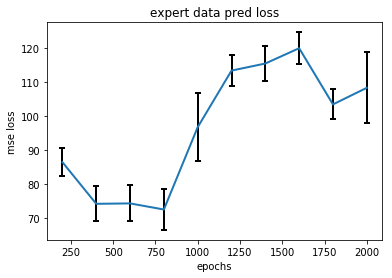

In [21]:
# data2M
timestamp = "Feb28_22-15-11"
param_path = "../data/data2M/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist, std_hist = [], []

for i in range(10):
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)


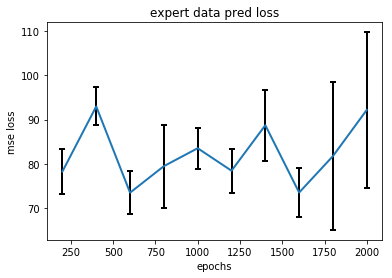

In [22]:
# data3M
timestamp = "Feb28_22-11-54"
param_path = "../data/data3M/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist, std_hist = [], []

for i in range(10):
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

### 反復学習

(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)


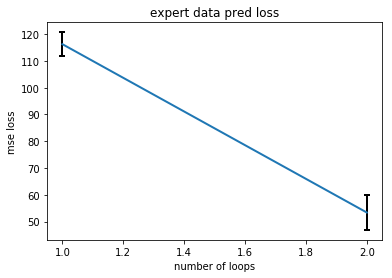

In [12]:
mean_hist = []
std_hist = []
mean, std = eval_expert_loss(
    "Feb26_08-06-04",
    2000,
    "../data/loop0/param.pkl",
    "../data/data_expert.pkl"
)
mean_hist.append(mean)
std_hist.append(std)
mean, std = eval_expert_loss(
    "Feb27_09-34-00",
    2000,
    "../data/loop1/param.pkl",
    "../data/data_expert.pkl"
)
mean_hist.append(mean)
std_hist.append(std)

mean, std = eval_expert_loss(
    "Mar01_04-57-45",
    2000,
    "../data/loop2_abci/param.pkl",
    "../data/data_expert.pkl"
)
mean_hist.append(mean)
std_hist.append(std)

plt.errorbar([i+1 for i in range(len(mean_hist))],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("number of loops")
plt.ylabel("mse loss")
plt.show()

### ランダムデータ

(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)


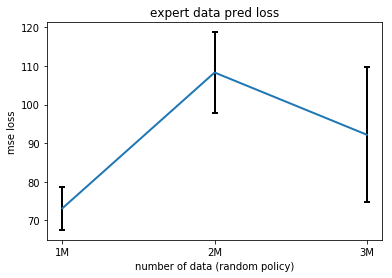

In [17]:
mean_hist = []
std_hist = []
mean, std = eval_expert_loss(
    "Mar01_00-20-11",
    2000,
    "../data/data1M/param.pkl",
    "../data/data_expert.pkl"
)
mean_hist.append(mean)
std_hist.append(std)
mean, std = eval_expert_loss(
    "Feb28_22-15-11",
    2000,
    "../data/data2M/param.pkl",
    "../data/data_expert.pkl"
)
mean_hist.append(mean)
std_hist.append(std)
mean, std = eval_expert_loss(
    "Feb28_22-11-54",
    2000,
    "../data/data3M/param.pkl",
    "../data/data_expert.pkl"
)
mean_hist.append(mean)
std_hist.append(std)

plt.errorbar([str(i+1)+"M" for i in range(3)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("number of data (random policy)")
plt.ylabel("mse loss")
plt.show()

### あとは同じランダムデータ数でどうなるか

In [9]:
# random data
timestamp = "Feb26_08-06-04"
param_path = "../data/loop0/param.pkl"
data_path = "../data/loop0/test.pkl"

score = eval_expert_loss(timestamp, 2000, param_path, data_path)
print(score)

 10%|█         | 1/10 [00:00<00:01,  8.50it/s]

(1000, 1000, 6) (1000, 1000, 17)


100%|██████████| 10/10 [00:01<00:00,  7.82it/s]

34.14352
